# Example: Two Double Gaussians

This notebook demonstrates fitting two peaks, each modeled as a double Gaussian (narrow core + wide component with shared mean).

In [32]:
import fitle as fl
import numpy as np
import matplotlib.pyplot as plt

## Generate Synthetic Data

Two peaks, each a double Gaussian.

In [37]:
np.random.seed(72)
# Peak 1: double gaussian at x=3
n1_core, n1_wide = 4000, 1000
mu1_true = 3.0
sigma1_core_true, sigma1_wide_true = 0.2, 0.6
# Peak 2: double gaussian at x=7
n2_core, n2_wide = 3000, 1500
mu2_true = 7.0
sigma2_core_true, sigma2_wide_true = 0.3, 0.8
# Background: exp
n_bkg = 2000
tau_true = 3.0  # decay constant
x_min, x_max = 0, 10  # data range

# Generate
data = np.concatenate([
    np.random.normal(mu1_true, sigma1_core_true, n1_core),
    np.random.normal(mu1_true, sigma1_wide_true, n1_wide),
    np.random.normal(mu2_true, sigma2_core_true, n2_core),
    np.random.normal(mu2_true, sigma2_wide_true, n2_wide),
    x_min - tau_true * np.log(1 - np.random.uniform(0, 1 - np.exp(-(x_max - x_min)/tau_true), n_bkg)),  # truncated exp
])
print(f"Total events: {len(data)}")

Total events: 11500


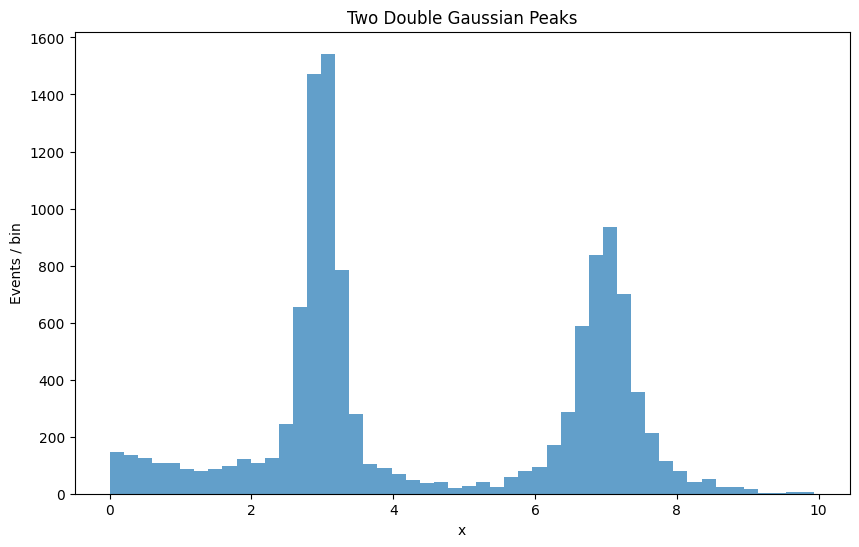

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, alpha=0.7)
plt.xlabel('x')
plt.ylabel('Events / bin')
plt.title('Two Double Gaussian Peaks')
plt.show()

## Building the Model

Each peak is a double Gaussian: $N_{core} \cdot G(\mu, \sigma_{core}) + N_{wide} \cdot G(\mu, \sigma_{wide})$

In [ ]:
# Peak 1: double gaussian with shared mean
mu1 = fl.Param(0, 5)(3.0)('mu1')
sigma1_core, sigma1_wide = +fl.Param, +fl.Param
N1_core, N1_wide = +fl.Param, +fl.Param

# Set starting values
sigma1_core = sigma1_core(0.2)
sigma1_wide = sigma1_wide(0.6)
N1_core = N1_core(4000)
N1_wide = N1_wide(1000)

peak1 = N1_core * fl.gaussian(mu=mu1, sigma=sigma1_core) + \
        N1_wide * fl.gaussian(mu=mu1, sigma=sigma1_wide)

# Peak 2: double gaussian
mu2 = fl.Param(5, 10)(7.0)('mu2')
sigma2_core, sigma2_wide = +fl.Param, +fl.Param
N2_core, N2_wide = +fl.Param, +fl.Param

sigma2_core = sigma2_core(0.3)
sigma2_wide = sigma2_wide(0.8)
N2_core = N2_core(3000)
N2_wide = N2_wide(1500)

peak2 = N2_core * fl.gaussian(mu=mu2, sigma=sigma2_core) + \
        N2_wide * fl.gaussian(mu=mu2, sigma=sigma2_wide)

# Background
tau, N_background = +fl.Param, +fl.Param
tau = tau(3.0)
N_background = N_background(2000)
background = N_background * fl.exponential(tau)

# Full model
model = peak1 + peak2 + background

print(f"Parameters: {[p.name for p in model.params]}")
print(f"\nModel: {model}")

## Fitting

In [36]:
cost = fl.Cost.chi2(data, bins=50)

fit_result = fl.fit(model | cost)
fit_result

ValueError: Chi2 calculation requires that all observed counts (y) be non-zero unless zero_method is set to 'absolute'.

## Plotting Results

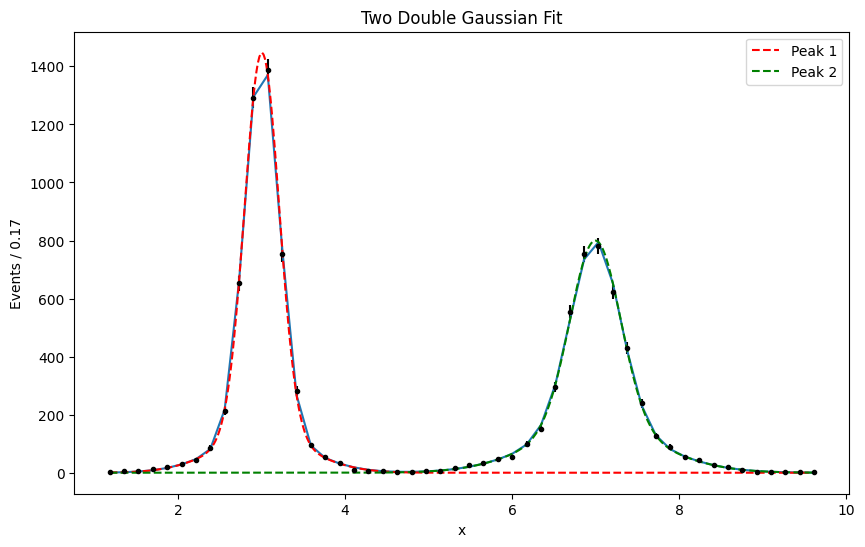

In [25]:
plt.figure(figsize=(10, 6))

fit_result.plot_data()
fit_result.plot_fit()

x = np.linspace(fit_result.x.min(), fit_result.x.max(), 500)
bw = fit_result.bin_width

plt.plot(x, peak1(x) * bw, 'r--', label='Peak 1')
plt.plot(x, peak2(x) * bw, 'g--', label='Peak 2')

plt.xlabel('x')
plt.ylabel(f'Events / {bw:.2f}')
plt.title('Two Double Gaussian Fit')
plt.legend()
plt.show()

## Fit Results

In [26]:
print("=== Peak 1 ===")
print(f"mu1: {fit_result.values['mu1']:.3f} ± {fit_result.errors['mu1']:.3f} (true: {mu1_true})")
print(f"N1_core: {fit_result.values['N1_core']:.0f}, N1_wide: {fit_result.values['N1_wide']:.0f}")
print(f"sigma1_core: {fit_result.values['sigma1_core']:.3f}, sigma1_wide: {fit_result.values['sigma1_wide']:.3f}")

print("\n=== Peak 2 ===")
print(f"mu2: {fit_result.values['mu2']:.3f} ± {fit_result.errors['mu2']:.3f} (true: {mu2_true})")
print(f"N2_core: {fit_result.values['N2_core']:.0f}, N2_wide: {fit_result.values['N2_wide']:.0f}")
print(f"sigma2_core: {fit_result.values['sigma2_core']:.3f}, sigma2_wide: {fit_result.values['sigma2_wide']:.3f}")

=== Peak 1 ===
mu1: 3.003 ± 0.004 (true: 3.0)
N1_core: 3989, N1_wide: 994
sigma1_core: 0.206, sigma1_wide: 0.569

=== Peak 2 ===
mu2: 6.996 ± 0.006 (true: 7.0)
N2_core: 2849, N2_wide: 1634
sigma2_core: 0.300, sigma2_wide: 0.760
